## 第15章 语义分割
语义分割是一种像素级别的处理图像方式，比目标检测其更加精确，能够自动从图像中划分出对象区域并识别对象区域中的类别，比如下面这个效果。

## 15.1 数据概览
本章主要使用如下数据。
- ImageSets/Segmentation目录下的数据，说明哪些用来训练，哪些数据用来测试。
- JPEGImages目录下的数据，这是jpg图像数据。
- SegmentationClass目录下的数据，这相当于标签数据。  
导入需要的库。

In [1]:
# 导入需要的库
import os
import sys
import time
import copy
import torch
import numpy as np
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet34
from PIL import Image
import torchvision.transforms as tfs
from datetime import datetime
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

查看其中一张图像及标签信息。

In [2]:
im_show1 = Image.open('../data/VOC2012/JPEGImages/2007_000480.jpg')
label_show1 = Image.open('../data/VOC2012/SegmentationClass/2007_000480.png').convert('RGB')

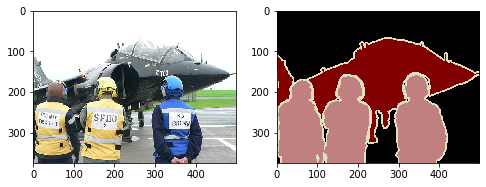

In [3]:
plt.figure(num='result',figsize=(8,6))
plt.subplot(1,2,1)
plt.imshow(im_show1)
plt.subplot(1,2,2)
plt.imshow(label_show1)

图15-1  图像及对应语义分割标签
左边就是真实的图片，右边就是分割之后的结果。

## 15.2 数据预处理
	定义一个读取图像的函数，具体读取哪些图像根据 train.txt 和 val.txt 配置文件，这里先指定图像的路径，之后根据图像名称生成批量的时候再读入图像，并做一些数据预处理。  
1）定义读取数据函数。

In [5]:
voc_root = '../data/VOC2012'

def read_images(root=voc_root, train=True):
    txt_fname = root + '/ImageSets/Segmentation/' + ('train.txt' if train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    data = [os.path.join(root, 'JPEGImages', i+'.jpg') for i in images]
    label = [os.path.join(root, 'SegmentationClass', i+'.png') for i in images]
    return data, label

2）使用数据增强方法。

In [6]:
def voc_random_crop(feature, label, height, width):
    """
    随机裁剪特征和标签.为了使裁剪的区域相同，不能直接使用RandomCrop，
    采用先获取参数(Get parameters)，然后进行裁剪(crop）
    """
    i,j,h,w = tfs.RandomCrop.get_params(feature, output_size=(height, width))
    feature = tfs.functional.crop(feature, i, j, h, w)
    label = tfs.functional.crop(label, i, j, h, w)
    return feature, label

3）浏览预处理后的一张图像及对应标签。

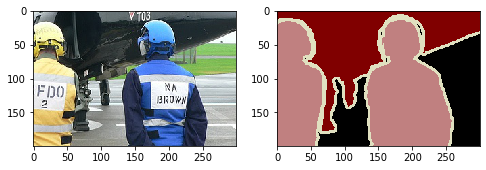

In [7]:
plt.figure(num='result',figsize=(8,6))
crop_im1, crop_label1 = voc_random_crop(im_show1, label_show1, 200, 300)
plt.subplot(1,2,1)
plt.imshow(crop_im1)
plt.subplot(1,2,2)
plt.imshow(crop_label1)

 图15-2 预处理后的1张图像及对应语义分割标签  
 4）定义类别标签及对应RGB值。

In [8]:
#定义20类别以及背景类别名称
classes = ['background','aeroplane','bicycle','bird','boat',
           'bottle','bus','car','cat','chair','cow','diningtable',
           'dog','horse','motorbike','person','potted plant',
           'sheep','sofa','train','tv/monitor']

# 定义每个标签的RGB值
colormap = [[0,0,0],[128,0,0],[0,128,0], [128,128,0], [0,0,128],
            [128,0,128],[0,128,128],[128,128,128],[64,0,0],[192,0,0],
            [64,128,0],[192,128,0],[64,0,128],[192,0,128],
            [64,128,128],[192,128,128],[0,64,0],[128,64,0],
            [0,192,0],[128,192,0],[0,64,128]]


5）定义每个像素的类别标签索引。  
为每个像素的类别标签数字化，即将一个类别的 RGB 值对应到一个整数上，通过这种一一对应的关系，能够将标签图像变成一个矩阵，矩阵和原图像一样大，但是只有一个通道数，也就是 (h, w) ，其中每个数值代表像素的类别。

In [10]:
cm2lbl = np.zeros(256**3) # 每个像素点有 0 ~ 255 的选择，RGB 三个通道
for i,cm in enumerate(colormap):
    cm2lbl[(cm[0]*256+cm[1])*256+cm[2]] = i # 建立索引

def image2label(img):
    data = np.array(img, dtype='int32')
    idx = (data[:, :, 0] * 256 + data[:, :, 1]) * 256 + data[:, :, 2]
    return np.array(cm2lbl[idx], dtype='int64') # 根据索引得到 label 矩阵

6）图像标签数字化实例。

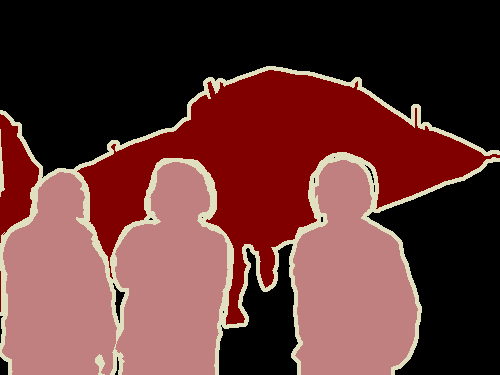

In [11]:
label_im = Image.open('../data/VOC2012/SegmentationClass/2007_000480.png').convert('RGB')
label_im

In [12]:
label = image2label(label_im)
label.shape

(375, 500)

In [27]:
label[100:110, 190:200]

array([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int64)

由此可以看到上面的像素点由 0 和 1 构成，0 表示背景，1 表示飞机这个类别。  
7）对数据进行预处理。  
首先随机裁剪（random crop）出固定大小的区域，然后对数据进行正则化。

In [14]:
def img_transforms(img, label, height, width):
    img, label = voc_random_crop(img, label, height, width)
    img_tfs = tfs.Compose([
        tfs.ToTensor(),
        tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    img = img_tfs(img)
    label = image2label(label)
    label = torch.from_numpy(label)
    return img, label

创建生成自定义训练集函数。定义一个 COVSegDataset 继承于 torch.utils.data.Dataset，以构成自定义训练集。

In [15]:
class VOCSegDataset(Dataset):
    '''
    构建训练集
    '''
    def __init__(self, train, crop_size, transforms):
        self.crop_size = crop_size
        self.transforms = transforms
        data_list, label_list = read_images(train=train)
        self.data_list = self._filter(data_list)
        self.label_list = self._filter(label_list)
        print('Read ' + str(len(self.data_list)) + ' images')

    def _filter(self, images): # 过滤掉图片大小小于 crop 大小的图片
        return [im for im in images if (Image.open(im).size[1] >= self.crop_size[0] and 
                                        Image.open(im).size[0] >= self.crop_size[1])]

    def __getitem__(self, idx):
        img = self.data_list[idx]
        label = self.label_list[idx]
        img = Image.open(img)
        label = Image.open(label).convert('RGB')
        img, label = self.transforms(img, label, self.crop_size[0],self.crop_size[1])
        return img, label

    def __len__(self):
        return len(self.data_list)

生成自定义数据集。

In [16]:
# 实例化数据集
input_shape = (320, 480)
voc_train = VOCSegDataset(True, input_shape, img_transforms)
voc_test = VOCSegDataset(False, input_shape, img_transforms)

train_data = DataLoader(voc_train, 32, shuffle=True, num_workers=0)
valid_data = DataLoader(voc_test, 64, num_workers=0)

Read 1114 images
Read 1078 images


## <font color=blue>说明：因当前是在Windows下运行，故这里把num_workers设置为0，如果在Linux环境下运行，则可将该值设置为大于0的整数。</font>

## 15.3 构建模型
	构建模型的基本思路，以全卷积网络为基础，全卷积网络前面是一个去掉全连接层的预训练ResNet34网络，同时去掉最后的平均池化层（AvgPool）和全连接层（FC）为 1x1的卷积，输出和类别数目相同的通道数，比如VOC2012 数据集是21分类，那么输出的通道数就是21，然后接一个转置卷积将结果变成输入的形状大小，最后在每个像素上做一个分类问题，用交叉熵作为损失函数。  
1）初始化权重。  
	通常训练模型时可以随机初始化权重，但是在全卷积网络中，使用随机初始化的权重将会需要大量的时间进行训练，这里卷积层使用在数据集ImageNet 上预训练的权重，转置卷积我们使用什么样的初始权重使用双线性核方法（Bilinear Kernel）。

In [17]:
# 使用双线性核方法初始化权重
def bilinear_kernel(in_channels, out_channels, kernel_size):
    '''
    返回初始化权重
    '''
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype='float32')
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight)

2）使用1张图测试权重初始化的效果。  
导入图像数据。  

(281, 500, 3)


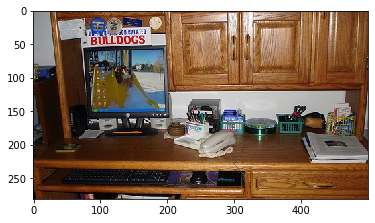

In [18]:
x = Image.open('../data/VOC2012/JPEGImages/2007_005210.jpg')
x = np.array(x)
plt.imshow(x)
print(x.shape)

 图15-3 原图像 
可视化初始化的图像。

(562, 1000, 3)


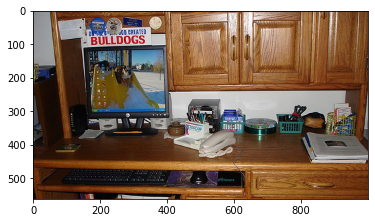

In [19]:
x = torch.from_numpy(x.astype('float32')).permute(2, 0, 1).unsqueeze(0)
# 定义转置卷积
conv_trans = nn.ConvTranspose2d(3, 3, 4, 2, 1)
# 将其定义为 bilinear kernel
conv_trans.weight.data = bilinear_kernel(3, 3, 4)

y = conv_trans(x).data.squeeze().permute(1, 2, 0).numpy()
plt.imshow(y.astype('uint8'))
print(y.shape)

图15-4 处理后的图像  
	从图15-4可以看到通过双线性核进行转置卷积，图像的大小扩大了一倍，但是图像看上去仍然非常清楚，所以这种方式的上采样具有很好的效果。  
3）使用预训练模型。

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = 21 # 21分类，1个背景，20个物体
pretrained_net=resnet34(pretrained=True) # 设置True，表明要加载使用训练好的参数

4）构建全卷积网络。  
定义网络结构，去掉最后的平均池化层（AvgPool）和全连接层（FC）替换为1x1的卷积，使用list(pretrained_net.children())[:-2] 就能够取到倒数第三层，取出最后的三个结果进行合并，详细代码如下：

In [23]:
class fcn(nn.Module):
    def __init__(self, num_classes):
        super(fcn, self).__init__()

        self.stage1 = nn.Sequential(*list(pretrained_net.children())[:-4]) # 第一段
        self.stage2 = list(pretrained_net.children())[-4] # 第二段
        self.stage3 = list(pretrained_net.children())[-3] # 第三段

        self.scores1 = nn.Conv2d(512, num_classes, 1)
        self.scores2 = nn.Conv2d(256, num_classes, 1)
        self.scores3 = nn.Conv2d(128, num_classes, 1)

        self.upsample_8x = nn.ConvTranspose2d(num_classes, num_classes, 16, 8, 4, bias=False)
        self.upsample_8x.weight.data = bilinear_kernel(num_classes, num_classes, 16) # 使用双线性 kernel

        self.upsample_4x = nn.ConvTranspose2d(num_classes, num_classes, 4, 2, 1, bias=False)
        self.upsample_4x.weight.data = bilinear_kernel(num_classes, num_classes, 4) # 使用双线性 kernel

        self.upsample_2x = nn.ConvTranspose2d(num_classes, num_classes, 4, 2, 1, bias=False)   
        self.upsample_2x.weight.data = bilinear_kernel(num_classes, num_classes, 4) # 使用双线性 kernel


    def forward(self, x):
        x = self.stage1(x)
        s1 = x # 1/8

        x = self.stage2(x)
        s2 = x # 1/16

        x = self.stage3(x)
        s3 = x # 1/32

        s3 = self.scores1(s3)
        s3 = self.upsample_2x(s3)
        s2 = self.scores2(s2)
        s2 = s2 + s3

        s1 = self.scores3(s1)
        s2 = self.upsample_4x(s2)
        s = s1 + s2

        s = self.upsample_8x(s)
        return s

5）实例化模型。

In [24]:
net = fcn(num_classes)
net = net.to(device)

## 15.4 训练模型
1）定义损失函数及优化器。首先生成混淆矩阵函数。

In [25]:
def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
    return hist

接着构建优化器。

In [27]:
class ScheduledOptim(object):
    '''A wrapper class for learning rate scheduling'''
 
    def __init__(self, optimizer):
        self.optimizer = optimizer
        self.lr = self.optimizer.param_groups[0]['lr']
        self.current_steps = 0
 
    def step(self):
        "Step by the inner optimizer"
        self.current_steps += 1
        self.optimizer.step()
 
    def zero_grad(self):
        "Zero out the gradients by the inner optimizer"
        self.optimizer.zero_grad()
 
    def set_learning_rate(self, lr):
        self.lr = lr
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
 
    @property
    def learning_rate(self):
        return self.lr

In [28]:
criterion = nn.NLLLoss()
basic_optim = torch.optim.SGD(net.parameters(), lr=1e-2, weight_decay=1e-4)
optimizer = ScheduledOptim(basic_optim)

定义一些语义分割的常用指标，比如类别平均像素准确率（Mean Pixel Accuracy），均交并比（mean IU）等。

In [31]:
def label_accuracy_score(label_trues, label_preds, n_class):
    """返回评估指标.
      - 类别平均像素准确率(Mean Pixel Accuracy)
      - 平均交并比(mean IU)      
    """
    hist = np.zeros((n_class, n_class))
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    acc = np.diag(hist).sum() / hist.sum()
    acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)
    iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    mean_iu = np.nanmean(iu)
    
    return acc_cls, mean_iu

2）训练模型，具体实现代码如下。

In [33]:
for e in range(80):
    if e > 0 and e % 50 == 0:
        optimizer.set_learning_rate(optimizer.learning_rate * 0.1)
    train_loss = 0
    train_acc = 0
    train_mean_iu = 0

    prev_time = datetime.now()
    net = net.train()
    for data in train_data:
        im = data[0].to(device)
        labels = data[1].to(device)
        #正向传播
        out = net(im)
        out = F.log_softmax(out, dim=1) # (b, n, h, w)
        loss = criterion(out, labels)
        #反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        pred_labels = out.max(dim=1)[1].data.cpu().numpy()
        pred_labels = [i for i in pred_labels]

        true_labels = labels.data.cpu().numpy()
        true_labels = [i for i in true_labels]

        #eval_metrics = eval_semantic_segmentation(pred_labels, true_labels)
        acc_cls_acc,mean_iu=label_accuracy_score(true_labels, pred_labels, num_classes)

        train_acc += acc_cls_acc
        train_mean_iu += mean_iu

    net = net.eval()
    eval_loss = 0
    eval_acc = 0
    eval_mean_iu = 0
    for data in valid_data:
        with torch.no_grad():
            im = data[0].to(device)
            labels = data[1].to(device)
            # 正向传播
            out = net(im)
            out = F.log_softmax(out, dim=1)
            loss = criterion(out, labels)
            eval_loss += loss.item()

            pred_labels = out.max(dim=1)[1].data.cpu().numpy()
            pred_labels = [i for i in pred_labels]

            true_labels = labels.data.cpu().numpy()
            true_labels = [i for i in true_labels]

            
            acc_cls_acc,mean_iu=label_accuracy_score(true_labels, pred_labels, num_classes)

    eval_acc += acc_cls_acc
    eval_mean_iu += mean_iu

    cur_time = datetime.now()
    h, remainder = divmod((cur_time - prev_time).seconds, 3600)
    m, s = divmod(remainder, 60)
    epoch_str = ('Epoch: {}, Train Loss: {:.5f}, Train Acc: {:.5f}, Train Mean IU: {:.5f}, \
Valid Loss: {:.5f}, Valid Acc: {:.5f}, Valid Mean IU: {:.5f} '.format(
        e, train_loss / len(train_data), train_acc / len(train_data), train_mean_iu / len(train_data),
        eval_loss / len(valid_data), eval_acc, eval_mean_iu))
    time_str = 'Time: {:.0f}:{:.0f}:{:.0f}'.format(h, m, s)
    print(epoch_str + time_str + ' lr: {}'.format(optimizer.learning_rate))

C:\Users\wumgapp\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\wumgapp\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Epoch: 0, Train Loss: 0.83723, Train Acc: 0.26316, Train Mean IU: 0.18467, Valid Loss: 0.73614, Valid Acc: 0.30745, Valid Mean IU: 0.21360 Time: 0:0:43 lr: 0.01
Epoch: 1, Train Loss: 0.66413, Train Acc: 0.37438, Train Mean IU: 0.27411, Valid Loss: 0.63471, Valid Acc: 0.35638, Valid Mean IU: 0.27065 Time: 0:0:43 lr: 0.01
Epoch: 2, Train Loss: 0.57112, Train Acc: 0.45042, Train Mean IU: 0.32329, Valid Loss: 0.57000, Valid Acc: 0.42214, Valid Mean IU: 0.31529 Time: 0:0:43 lr: 0.01
Epoch: 3, Train Loss: 0.52004, Train Acc: 0.49409, Train Mean IU: 0.35952, Valid Loss: 0.52976, Valid Acc: 0.45773, Valid Mean IU: 0.34930 Time: 0:0:43 lr: 0.01
Epoch: 4, Train Loss: 0.47661, Train Acc: 0.51912, Train Mean IU: 0.38029, Valid Loss: 0.50159, Valid Acc: 0.48002, Valid Mean IU: 0.37600 Time: 0:0:44 lr: 0.01
Epoch: 5, Train Loss: 0.43613, Train Acc: 0.53963, Train Mean IU: 0.40196, Valid Loss: 0.48223, Valid Acc: 0.50173, Valid Mean IU: 0.37411 Time: 0:0:44 lr: 0.01
Epoch: 6, Train Loss: 0.41053, Tra

## 15.5 测试模型
1）定义测试模型函数。

In [34]:
net = net.eval()

In [35]:
# 定义预测函数
cm = np.array(colormap).astype('uint8')

def predict(img, label): # 预测结果
    img = img.unsqueeze(0).to(device)
    out = net(img)
    pred = out.max(1)[1].squeeze().cpu().data.numpy()
    pred = cm[pred]
    return pred, cm[label.numpy()]

2）可视化预测结果。

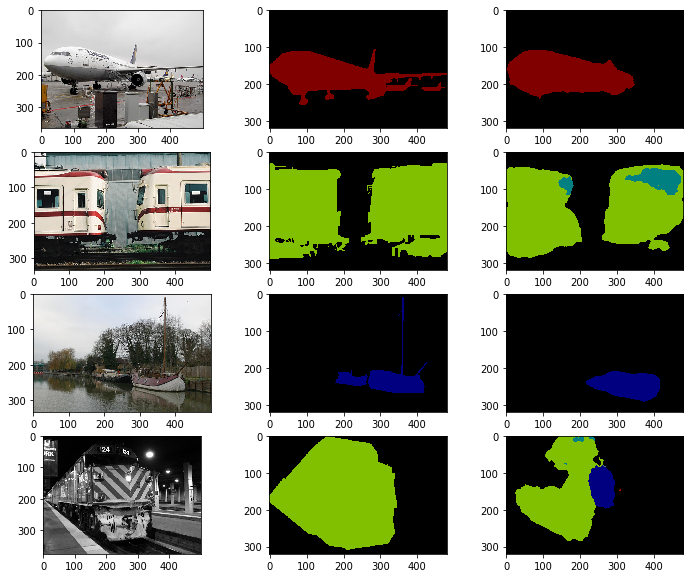

In [51]:
_,axes=plt.subplots(4, 3, figsize=(12, 10))
for i in range(4):
    test_data, test_label = voc_test[i]
    pred, label = predict(test_data, test_label)
    axes[i][0].imshow(Image.open(voc_test.data_list[i]))
    axes[i][1].imshow(label)
    axes[i][2].imshow(pred)

图15-5 可视化测试结果  
## 15.6 保存与恢复模型
1）保存模型。

In [55]:
##保存模型
torch.save(net, 'fcn.pth')

2）恢复模型。

In [56]:
## 加载模型
net_new = torch.load('fcn.pth')
net_new.eval()

fcn(
  (stage1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

在进行预测之前，必须调用 model.eval() 方法来将 dropout 和 batch normalization 层设置为验证模型。否则，只会生成前后不一致的预测结果.
保存和加载模型都是采用非常直观的语法并且都只需要几行代码即可实现。这种实现保存模型的做法将是采用 Python 的 pickle 模块来保存整个模型，这种做法的缺点就是序列化后的数据是属于特定的类和指定的字典结构，原因就是 pickle 并没有保存模型类别，而是保存一个包含该类的文件路径，因此，当在其他项目或者在 refactors 后采用都可能出现错误

In [58]:
## 保存模型
torch.save(net.state_dict(), 'fcn_dict.pth')

In [65]:
## 加载模型
net01 = fcn(num_classes)
net01.load_state_dict(torch.load('fcn_dict.pth'))
net01.eval()
net01.to(device)

fcn(
  (stage1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

在进行预测之前，必须调用model.eval()方法来将dropout层和正则化层设置为验证模型。否则，只会生成前后不一致的预测结果。保存与恢复模型都是采用非常直观的语法并且都只需要几行代码即可实现。这种实现保存模型的做法将是采用 Python 的 pickle 模块来保存整个模型，这种做法的缺点就是序列化后的数据是属于特定的类和指定的字典结构，原因就是pickle并没有保存模型类别，而是保存一个包含该类的文件路径，因此，当在其他项目或者在恢复模型后采用都可能出现错误。

In [66]:
def predict01(img, label): # 预测结果
    img = img.unsqueeze(0).to(device)
    out = net01(img)
    pred = out.max(1)[1].squeeze().cpu().data.numpy()
    pred = cm[pred]
    return pred, cm[label.numpy()]

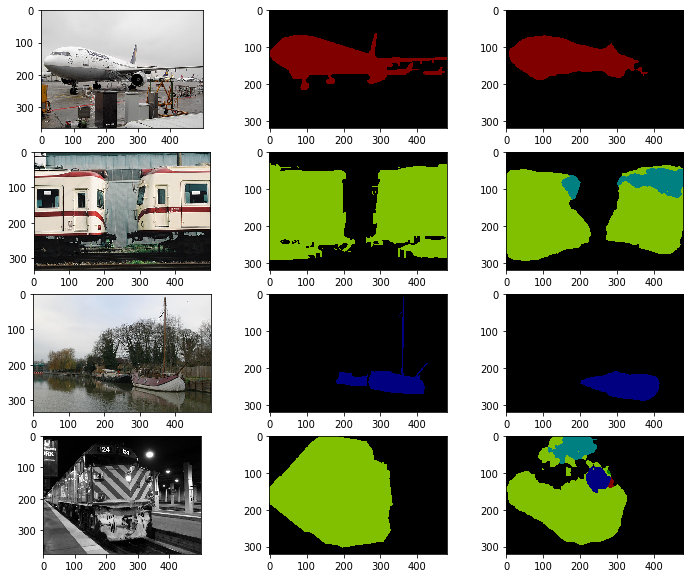

In [67]:
_,axes=plt.subplots(4, 3, figsize=(12, 10))
for i in range(4):
    test_data, test_label = voc_test[i]
    pred, label = predict01(test_data, test_label)
    axes[i][0].imshow(Image.open(voc_test.data_list[i]))
    axes[i][1].imshow(label)
    axes[i][2].imshow(pred)